In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load data
df = pd.read_csv('results/experiment_results_exp-2.csv')
df.columns

# df['error_mean'] = (np.rad2deg(df['error_s1']) + np.rad2deg(df['error_s2'])) / 2
# df['dist_s1_s2'] = np.rad2deg(np.abs(df['doas_ref_s1_az'] - df['doas_ref_s2_az']))
df['separation_angle'] = np.abs(np.rad2deg(np.abs(df['doas_ref_s1_az'] - df['doas_ref_s2_az'])))
df['correct_s1'] = (np.abs(np.rad2deg(df['error_s1'])) < df['separation_angle'] / 2).astype(float)
df['correct_s2'] = (np.abs(np.rad2deg(df['error_s2'])) < df['separation_angle'] / 2).astype(float)
df['correct'] = df['correct_s1'] + df['correct_s2']
df.columns  

Index(['target_doa', 'duration', 'snr', 'noise_type', 'add_reverberation',
       'loc_method', 'freq_min', 'freq_max', 'sv_method', 'nObs', 'seed',
       'sv_normalization', 'doas_est_idx_s1', 'doas_est_idx_s2',
       'doas_ref_idx_s1', 'doas_ref_idx_s2', 'doas_ref_s1_az',
       'doas_ref_s1_el', 'doas_ref_s2_az', 'doas_ref_s2_el', 'doas_est_s1_az',
       'doas_est_s1_el', 'doas_est_s2_az', 'doas_est_s2_el', 'error_s1',
       'error_s2', 'time', 'exp_name', 'separation_angle', 'correct_s1',
       'correct_s2', 'correct'],
      dtype='object')

<Axes: xlabel='separation_angle', ylabel='correct'>

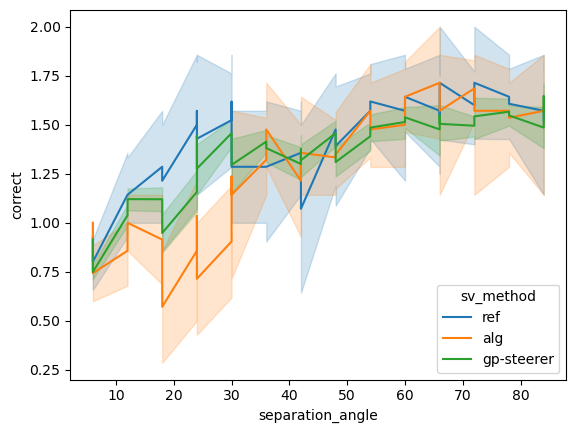

In [4]:
sns.lineplot(data=df, x='separation_angle', y='correct', hue='sv_method')